# Urdu Deepfake Audio Detection (Binary Classification)

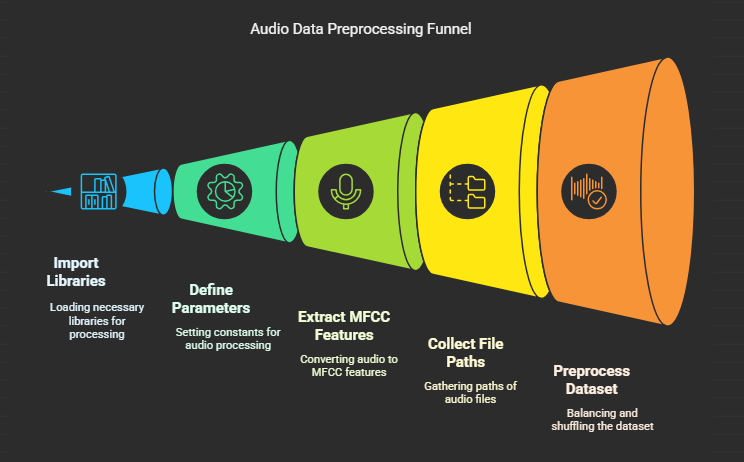


**Imports**: Libraries for handling audio files (librosa), numerical operations (numpy), file management (os), and data processing (pandas).

**Parameters**: Defines constants like SAMPLE_RATE (sample rate for audio), N_MFCC (number of MFCC coefficients), MAX_FRAMES (frame size for uniform input), and N_SAMPLES_PER_CLASS (samples per class).

**MFCC Extraction**: The extract_mfcc function processes each audio file by extracting MFCC features, padding/truncating the features to a fixed size, and flattening the array.

**File Collection**: The collect_file_paths function scans the dataset directory for both Bonafide (real) and Deepfake (spoofed) audio files and returns their file paths.

**Preprocessing Function**: preprocess_dataset collects the audio files, extracts MFCC features, balances the dataset (limits to 500 samples per class), shuffles the data, and saves the features (X.npy) and labels (y.npy) to disk along with metadata (file_list.csv).

In [ ]:
!git clone https://huggingface.co/datasets/CSALT/deepfake_detection_dataset_urdu

Cloning into 'deepfake_detection_dataset_urdu'...
remote: Enumerating objects: 6796, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6796 (delta 0), reused 0 (delta 0), pack-reused 6793 (from 1)
Receiving objects: 100% (6796/6796), 957.64 KiB | 5.70 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (6796/6796), done.
Filtering content: 100% (6794/6794), 1.82 GiB | 15.95 MiB/s, done.


In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.utils import shuffle
import random

# Parameters
SAMPLE_RATE = 16000  # Standard sample rate for audio files (16kHz)
N_MFCC = 13          # Number of MFCC (Mel-frequency cepstral coefficients) features to extract
MAX_FRAMES = 300     # Maximum number of frames in the audio; used for padding or truncating
N_SAMPLES_PER_CLASS = 500  # Limit the number of samples for each class (Bonafide and Deepfake)

# Function to extract MFCC features from an audio file
def extract_mfcc(file_path):
    """Extract MFCC features from an audio file"""
    try:
        # Load the audio file using librosa with the specified sample rate
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Extract MFCC features from the audio signal
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)

        # Pad or truncate the MFCC array to a fixed size (MAX_FRAMES)
        if mfcc.shape[1] > MAX_FRAMES:
            mfcc = mfcc[:, :MAX_FRAMES]  # Truncate if it exceeds MAX_FRAMES
        else:
            # Pad with zeros if the MFCC array has fewer frames than MAX_FRAMES
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_FRAMES - mfcc.shape[1])), mode='constant')

        # Flatten the MFCC array to a 1D vector for use in machine learning models
        mfcc_flat = mfcc.flatten()
        return mfcc_flat  # Return the flattened MFCC array
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # If an error occurs, return None

# Function to collect file paths recursively from the dataset directory
def collect_file_paths(dataset_dir):
    """Collect file paths and labels from dataset recursively"""
    bonafide_files = []  # List to store Bonafide file paths
    deepfake_files = []  # List to store Deepfake file paths

    # Search for the Bonafide folder in the dataset directory (allowing for different folder names)
    bonafide_dir = None
    for possible_name in ['Bonafide', 'bonafide', 'Bonafide_Audio', 'Real']:
        candidate = os.path.join(dataset_dir, possible_name)
        if os.path.isdir(candidate):  # Check if the directory exists
            bonafide_dir = candidate  # Set the bonafide directory if found
            break

    if bonafide_dir is None:
        print("Error: Could not find Bonafide folder in", dataset_dir)
        print("Checked for: Bonafide, bonafide, Bonafide_Audio, Real")
        return [], []  # Return empty lists if the Bonafide folder was not found

    # Recursively collect all files in the Bonafide directory
    print(f"Scanning Bonafide folder: {bonafide_dir}")
    for root, _, files in os.walk(bonafide_dir):  # Walk through the directory tree
        for file in files:
            if file.lower().endswith('.wav'):  # Only process .wav files
                file_path = os.path.join(root, file)
                bonafide_files.append(file_path)  # Add file to the list

    # Recursively collect all files in the Deepfake directory (Spoofed_Tacotron, Spoofed_TTS, etc.)
    for spoof_dir_name in ['Spoofed_Tacotron', 'spoofed_tacotron', 'Spoofed_TTS', 'spoofed_tts']:
        spoof_dir = os.path.join(dataset_dir, spoof_dir_name)
        if os.path.isdir(spoof_dir):  # Check if the spoof directory exists
            print(f"Scanning Deepfake folder: {spoof_dir}")
            for root, _, files in os.walk(spoof_dir):  # Walk through the directory tree
                for file in files:
                    if file.lower().endswith('.wav'):  # Only process .wav files
                        file_path = os.path.join(root, file)
                        deepfake_files.append(file_path)  # Add file to the list

    return bonafide_files, deepfake_files  # Return the lists of file paths

# Main preprocessing function to process the dataset and save features
def preprocess_dataset(dataset_dir, output_dir='preprocessed'):
    """Preprocess audio dataset and save features"""
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Collect file paths for both Bonafide and Deepfake categories
    bonafide_files, deepfake_files = collect_file_paths(dataset_dir)
    print(f"Found {len(bonafide_files)} Bonafide files and {len(deepfake_files)} Deepfake files")

    # Validate dataset by checking if we have sufficient files for both classes
    if len(bonafide_files) == 0:
        raise ValueError("No Bonafide files found. Cannot proceed with preprocessing.")
    if len(deepfake_files) == 0:
        raise ValueError("No Deepfake files found. Cannot proceed with preprocessing.")

    # Balance the dataset by ensuring an equal number of samples for each class
    random.seed(42)  # For reproducibility of random selection
    max_samples = min(N_SAMPLES_PER_CLASS, len(bonafide_files), len(deepfake_files))
    if max_samples < N_SAMPLES_PER_CLASS:
        print(f"Warning: Reducing samples per class to {max_samples} due to limited files")

    # Randomly sample the required number of files from each class
    bonafide_files = random.sample(bonafide_files, max_samples)
    deepfake_files = random.sample(deepfake_files, max_samples)

    # Initialize lists to hold the features (X), labels (y), and file metadata
    X = []  # Features (MFCC)
    y = []  # Labels (0 for Bonafide, 1 for Deepfake)
    file_list = []  # List to hold file paths and labels for metadata

    # Process Bonafide files (label = 0)
    print("Processing Bonafide files...")
    for file_path in bonafide_files:
        mfcc = extract_mfcc(file_path)  # Extract MFCC features
        if mfcc is not None:
            X.append(mfcc)  # Append MFCC features to X
            y.append(0)  # Label for Bonafide is 0
            file_list.append({'file_path': file_path, 'label': 'Bonafide'})  # Store file metadata

    # Process Deepfake files (label = 1)
    print("Processing Deepfake files...")
    for file_path in deepfake_files:
        mfcc = extract_mfcc(file_path)  # Extract MFCC features
        if mfcc is not None:
            X.append(mfcc)  # Append MFCC features to X
            y.append(1)  # Label for Deepfake is 1
            file_list.append({'file_path': file_path, 'label': 'Deepfake'})  # Store file metadata

    # Convert X and y to NumPy arrays for model input
    X = np.array(X)
    y = np.array(y)

    # Validate that valid features were extracted
    if len(X) == 0:
        raise ValueError("No valid features extracted. Check audio files for errors.")

    # Shuffle the dataset for randomization
    X, y = shuffle(X, y, random_state=42)

    # Save the preprocessed features and labels to disk
    np.save(os.path.join(output_dir, 'X.npy'), X)  # Save feature matrix X
    np.save(os.path.join(output_dir, 'y.npy'), y)  # Save label array y

    # Save file metadata (file paths and labels) to a CSV file
    file_df = pd.DataFrame(file_list)  # Create a DataFrame from the file list
    file_df.to_csv(os.path.join(output_dir, 'file_list.csv'), index=False)  # Save metadata to CSV

    print(f"Preprocessed {len(X)} samples with {X.shape[1]} features each")
    print(f"Saved features to {output_dir}/X.npy and labels to {output_dir}/y.npy")
    print(f"Saved file list to {output_dir}/file_list.csv")

# Main entry point of the script
if __name__ == "__main__":
    dataset_dir = "/content/deepfake_detection_dataset_urdu"  # Path to the dataset directory
    preprocess_dataset(dataset_dir)  # Run the preprocessing function


Scanning Bonafide folder: /content/deepfake_detection_dataset_urdu/Bonafide
Scanning Deepfake folder: /content/deepfake_detection_dataset_urdu/Spoofed_Tacotron
Scanning Deepfake folder: /content/deepfake_detection_dataset_urdu/Spoofed_TTS
Found 3398 Bonafide files and 3396 Deepfake files
Processing Bonafide files...
Processing Deepfake files...
Preprocessed 1000 samples with 3900 features each
Saved features to preprocessed/X.npy and labels to preprocessed/y.npy
Saved file list to preprocessed/file_list.csv


In [ ]:
import numpy as np
y = np.load('preprocessed/y.npy')
print(f"Bonafide samples (label 0): {sum(y == 0)}")
print(f"Deepfake samples (label 1): {sum(y == 1)}")

Bonafide samples (label 0): 500
Deepfake samples (label 1): 500


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib
import os

# Load preprocessed data
X = np.load('preprocessed/X.npy')
y = np.load('preprocessed/y.npy')

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize models
svm_model = SVC(probability=True, random_state=42)
lr_model = LogisticRegression(random_state=42)
perceptron_model = Perceptron(random_state=42)
dnn_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)

# Train models
print("Training SVM...")
svm_model.fit(X_train, y_train)
print("Training Logistic Regression...")
lr_model.fit(X_train, y_train)
print("Training Perceptron...")
perceptron_model.fit(X_train, y_train)
print("Training DNN...")
dnn_model.fit(X_train, y_train)

# Make predictions
models = {'SVM': svm_model, 'Logistic Regression': lr_model, 'Perceptron': perceptron_model, 'DNN': dnn_model}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else (y_pred).astype(float)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob) if hasattr(model, 'predict_proba') else None

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if auc_roc is not None:
        print(f"AUC-ROC: {auc_roc:.4f}")
    else:
        print("AUC-ROC: Not available (model does not support probabilities)")

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save models
joblib.dump(svm_model, 'models/svm_model.pkl')
joblib.dump(lr_model, 'models/lr_model.pkl')
joblib.dump(perceptron_model, 'models/perceptron_model.pkl')
joblib.dump(dnn_model, 'models/dnn_model.pkl')
print("\nModels saved to 'models/' directory")

Training SVM...
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Perceptron...
Training DNN...

SVM Results:
Accuracy: 0.8700
Precision: 0.8854
Recall: 0.8500
F1-Score: 0.8673
AUC-ROC: 0.9374

Logistic Regression Results:
Accuracy: 0.7000
Precision: 0.7083
Recall: 0.6800
F1-Score: 0.6939
AUC-ROC: 0.7693

Perceptron Results:
Accuracy: 0.6750
Precision: 0.6804
Recall: 0.6600
F1-Score: 0.6701
AUC-ROC: Not available (model does not support probabilities)

DNN Results:
Accuracy: 0.7650
Precision: 0.7849
Recall: 0.7300
F1-Score: 0.7565
AUC-ROC: 0.8635

Models saved to 'models/' directory


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load preprocessed data
X = np.load('preprocessed/X.npy')
y = np.load('preprocessed/y.npy')

# Split into training and test sets (same split as training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Load models
svm_model = joblib.load('models/svm_model.pkl')
lr_model = joblib.load('models/lr_model.pkl')
perceptron_model = joblib.load('models/perceptron_model.pkl')
dnn_model = joblib.load('models/dnn_model.pkl')

# Evaluate models
models = {'SVM': svm_model, 'Logistic Regression': lr_model, 'Perceptron': perceptron_model, 'DNN': dnn_model}
results = []

for name, model in models.items():
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Append results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc if auc_roc is not None else 'N/A'
    })

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bonafide', 'Deepfake'], yticklabels=['Bonafide', 'Deepfake'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.close()

# Create comparison table
results_df = pd.DataFrame(results)
print("\nModel Comparison Table:")
print(results_df.to_string(index=False))
results_df.to_csv('model_comparison.csv', index=False)

# Plot comparison bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, results_df[metric], width, label=metric)

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models.keys())
ax.set_title('Model Performance Comparison')
ax.set_ylabel('Score')
ax.legend()
plt.tight_layout()
plt.savefig('model_comparison_bar_chart.png')
plt.close()

print("\nConfusion matrices saved as PNG files.")
print("Comparison table saved to 'model_comparison.csv'")
print("Comparison bar chart saved to 'model_comparison_bar_chart.png'")


Model Comparison Table:
              Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
                SVM     0.870   0.885417    0.85  0.867347   0.9374
Logistic Regression     0.700   0.708333    0.68  0.693878   0.7693
         Perceptron     0.675   0.680412    0.66  0.670051      N/A
                DNN     0.765   0.784946    0.73  0.756477  0.86355

Confusion matrices saved as PNG files.
Comparison table saved to 'model_comparison.csv'
Comparison bar chart saved to 'model_comparison_bar_chart.png'


In [ ]:
!pip install gradio
import gradio as gr
import numpy as np
import librosa
import joblib

# Parameters (matching preprocessing)
SAMPLE_RATE = 16000
N_MFCC = 13
MAX_FRAMES = 300

# Function to extract MFCC features from uploaded audio
def extract_mfcc(file_path):
    """Extract MFCC features from an audio file"""
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)

        # Pad or truncate to MAX_FRAMES
        if mfcc.shape[1] > MAX_FRAMES:
            mfcc = mfcc[:, :MAX_FRAMES]
        else:
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_FRAMES - mfcc.shape[1])), mode='constant')

        # Flatten to 1D vector
        mfcc_flat = mfcc.flatten()
        return mfcc_flat
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

# Function to make prediction
def predict_audio(audio_file, model_choice):
    """Predict if the audio is Deepfake or Bonafide"""
    # Load the selected model
    model_map = {
        "SVM": joblib.load('models/svm_model.pkl'),
        "Logistic Regression": joblib.load('models/lr_model.pkl'),
        "DNN": joblib.load('models/dnn_model.pkl'),
        "Perceptron": joblib.load('models/perceptron_model.pkl')
    }
    model = model_map.get(model_choice)
    if model is None:
        return "Error: Model not found. Please ensure models are trained and saved.", None, None

    # Extract features
    features = extract_mfcc(audio_file)
    if features is None:
        return "Error: Failed to process audio file.", None, None

    # Reshape for prediction (1 sample)
    features = features.reshape(1, -1)

    # Make prediction
    prediction = model.predict(features)[0]
    label = "Bonafide" if prediction == 0 else "Deepfake"

    # Get confidence score (if available)
    confidence = None
    if hasattr(model, 'predict_proba'):
        prob = model.predict_proba(features)[0]
        confidence = prob[1] if prediction == 1 else prob[0]  # Probability of the predicted class

    # Prepare output message
    message = f"✅ Prediction: {label}"
    if confidence is not None:
        message += f" (Confidence: {confidence:.2%})"
    else:
        message += " (Confidence not available for this model)"

    return message, label, confidence

# Gradio interface
with gr.Blocks(title="Urdu Deepfake Audio Detector") as app:
    gr.Markdown("# Urdu Deepfake Audio Detection")
    gr.Markdown("Upload an audio file to predict if it’s Bonafide or Deepfake.")

    with gr.Row():
        with gr.Column():
            # Audio file upload
            audio_input = gr.Audio(type="filepath", label="Upload Audio File")

            # Model selection (including Perceptron)
            model_choice = gr.Dropdown(
                choices=["SVM", "Logistic Regression", "DNN", "Perceptron"],
                value="SVM",
                label="Select Model"
            )

            # Predict button
            predict_btn = gr.Button("Predict", variant="primary")

        with gr.Column():
            # Output sections
            output_message = gr.Markdown(label="Prediction Result")
            output_label = gr.Label(label="Predicted Class")
            output_confidence = gr.Number(label="Confidence Score (%)", visible=True)

    # Connect button to prediction function
    predict_btn.click(
        fn=predict_audio,
        inputs=[audio_input, model_choice],
        outputs=[output_message, output_label, output_confidence]
    )

app.launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://30bf9bb1ca73a73752.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working director

In [ ]:
import gradio as gr
import numpy as np
import librosa
import joblib

# Parameters (matching preprocessing)
SAMPLE_RATE = 16000
N_MFCC = 13
MAX_FRAMES = 300

# Function to extract MFCC features from uploaded audio
def extract_mfcc(file_path):
    """Extract MFCC features from an audio file"""
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)

        # Pad or truncate to MAX_FRAMES
        if mfcc.shape[1] > MAX_FRAMES:
            mfcc = mfcc[:, :MAX_FRAMES]
        else:
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_FRAMES - mfcc.shape[1])), mode='constant')

        # Flatten to 1D vector
        mfcc_flat = mfcc.flatten()
        return mfcc_flat
    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

# Function to make prediction
def predict_audio(audio_file, model_choice):
    """Predict if the audio is Deepfake or Bonafide"""
    # Load the selected model
    model_map = {
        "SVM": joblib.load('models/svm_model.pkl'),
        "Logistic Regression": joblib.load('models/lr_model.pkl'),
        "DNN": joblib.load('models/dnn_model.pkl'),
        "Perceptron": joblib.load('models/perceptron_model.pkl')
    }
    model = model_map.get(model_choice)
    if model is None:
        return "Error: Model not found. Please ensure models are trained and saved.", None, None

    # Extract features
    features = extract_mfcc(audio_file)
    if features is None:
        return "Error: Failed to process audio file.", None, None

    # Reshape for prediction (1 sample)
    features = features.reshape(1, -1)

    # Make prediction
    prediction = model.predict(features)[0]
    label = "Bonafide" if prediction == 0 else "Deepfake"

    # Get confidence score (if available)
    confidence = None
    if hasattr(model, 'predict_proba'):
        prob = model.predict_proba(features)[0]
        confidence = prob[1] if prediction == 1 else prob[0]  # Probability of the predicted class

    # Prepare output message
    message = f"✅ Prediction: {label}"
    if confidence is not None:
        message += f" (Confidence: {confidence:.2%})"
    else:
        message += " (Confidence not available for this model)"

    return message, label, confidence

# Custom CSS for white and dark blue theme
css = """
:root {
    --primary-color: #0A2463;
    --secondary-color: #247BA0;
    --accent-color: #1E88E5;
    --background-color: #FFFFFF;
    --text-color: #333333;
    --container-color: #F5F7FA;
    --border-color: #E0E0E0;
}

body {
    background-color: var(--background-color);
    color: var(--text-color);
}

.gradio-container {
    max-width: 1200px !important;
    margin-left: auto !important;
    margin-right: auto !important;
}

.main-header {
    background-color: var(--primary-color);
    color: white;
    padding: 1.5rem;
    border-radius: 10px;
    margin-bottom: 1.5rem;
    text-align: center;
}

.main-header h1 {
    font-size: 2.5rem;
    font-weight: bold;
    margin-bottom: 0.5rem;
}

.main-header p {
    font-size: 1.1rem;
    opacity: 0.9;
}

.container {
    background-color: var(--container-color);
    border-radius: 10px;
    padding: 20px;
    border: 1px solid var(--border-color);
    box-shadow: 0 2px 10px rgba(0,0,0,0.05);
}

.result-box {
    background-color: var(--primary-color);
    color: white;
    padding: 15px;
    border-radius: 8px;
    margin-top: 10px;
}

button.primary {
    background-color: var(--primary-color) !important;
    color: white !important;
    border: none !important;
    padding: 10px 20px !important;
    font-weight: bold !important;
    transition: all 0.3s ease !important;
}

button.primary:hover {
    background-color: var(--secondary-color) !important;
    transform: translateY(-2px) !important;
    box-shadow: 0 4px 8px rgba(0,0,0,0.1) !important;
}

.footer {
    text-align: center;
    margin-top: 2rem;
    color: var(--text-color);
    opacity: 0.7;
    font-size: 0.9rem;
}

.dropdown {
    background-color: white !important;
    border: 1px solid var(--border-color) !important;
}

.label-container {
    border: 1px solid var(--border-color);
    border-radius: 8px;
    padding: 15px;
    background-color: white;
}

.confidence-meter {
    margin-top: 15px;
}
"""

# Create the Gradio interface with enhanced UI
with gr.Blocks(css=css, title="Urdu Deepfake Audio Detector") as app:
    # Header
    with gr.Column(elem_classes="main-header"):
        gr.Markdown("# Urdu Deepfake Audio Detector")
        gr.Markdown("Upload an audio file in Urdu to verify its authenticity")

    with gr.Row():
        with gr.Column(elem_classes="container"):
            gr.Markdown("### Input")

            # Audio file upload with custom styling
            audio_input = gr.Audio(
                type="filepath",
                label="Upload Urdu Audio File",
                elem_classes="audio-input"
            )

            # Model selection dropdown
            with gr.Column():
                gr.Markdown("### Select Model")
                model_choice = gr.Dropdown(
                    choices=["SVM", "Logistic Regression", "DNN", "Perceptron"],
                    value="SVM",
                    label="Choose Detection Model",
                    elem_classes="dropdown"
                )

            # Information about models
            with gr.Accordion("Model Information", open=False):
                gr.Markdown("""
                * **SVM**: Support Vector Machine - Good general-purpose model
                * **Logistic Regression**: Simple and interpretable
                * **DNN**: Deep Neural Network - More complex pattern recognition
                * **Perceptron**: Simple linear classifier
                """)

            # Predict button
            predict_btn = gr.Button("Analyze Audio", variant="primary", elem_classes="primary")

        with gr.Column(elem_classes="container"):
            gr.Markdown("### Results")

            # Output sections with improved styling - Using gr.Column instead of gr.Box
            with gr.Group(elem_classes="result-box"):
                output_message = gr.Markdown(label="Prediction Result")

            with gr.Group(elem_classes="label-container"):
                output_label = gr.Label(label="Predicted Class")

            with gr.Group(elem_classes="confidence-meter"):
                output_confidence = gr.Number(label="Confidence Score (%)", visible=True)

            # Instructions and explanation
            with gr.Accordion("How It Works", open=False):
                gr.Markdown("""
                1. The system extracts MFCC features from your audio
                2. These features are processed by the selected model
                3. The model classifies the audio as either genuine (Bonafide) or artificially generated (Deepfake)
                4. Confidence score indicates how certain the model is about its prediction
                """)

    # Footer
    gr.Markdown("© 2025 Urdu Deepfake Audio Detection Project", elem_classes="footer")

    # Connect button to prediction function
    predict_btn.click(
        fn=predict_audio,
        inputs=[audio_input, model_choice],
        outputs=[output_message, output_label, output_confidence]
    )

if __name__ == "__main__":
    app.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://77de748c59bc6ce3bf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
